In [17]:
import pandas as pd
import io
import re
import time
from contextlib import redirect_stdout
from tqdm import tqdm
from multiprocessing import Process, Queue

path_to_data = "../data/raw"

In [18]:
df_solutions_train = pd.read_excel(f'{path_to_data}/train/solutions.xlsx')
df_tests_train = pd.read_excel(f'{path_to_data}/train/tests.xlsx')
df_tasks_train = pd.read_excel(f'{path_to_data}/train/tasks.xlsx')

In [19]:
def replace_input_with_values(code, input_values):
    # Считаем количество вызовов input() в коде
    input_calls = len(re.findall(r'input\s*\(\s*\)', code))
    
    # Если нет вызовов input(), возвращаем исходный код
    if input_calls == 0:
        return code
    
    # Если input_values — строка, разделяем её на отдельные значения
    if isinstance(input_values, str):
        input_values_list = input_values.split(';')
    else:
        input_values_list = input_values
    
    # Заменяем каждый вызов input() на соответствующее значение
    if len(input_values_list)>1:
        for value in input_values_list:
            code = re.sub(r'input\s*\(\s*\)', f'{value}', code, count=1)
    else:
        code = re.sub(r'input\s*\(\s*\)', f'"{input_values}"', code)
    return code

def execute_code_with_timeout(code, input_values, timeout=0.5):
    def target(queue, code, input_values):
        # Заменяем вызовы input() на передачу данных напрямую
        code = replace_input_with_values(code, input_values)     
        #print(code)   
        # Перенаправляем стандартный вывод в буфер
        buffer = io.StringIO()
        with redirect_stdout(buffer):
            try:
                exec(code)
            except Exception as e:
                queue.put(f"Error: {str(e)}")
                return

        # Получаем результат вывода
        output = buffer.getvalue().strip()
        queue.put(output)

    q = Queue()
    p = Process(target=target, args=(q, code, input_values))
    p.start()
    p.join(timeout)

    if p.is_alive():
        p.terminate()
        p.join()
        return "Timeout"
    else:
        return q.get()

def checkout_tests(solutions, tests):
    # Добавляем колонки error_open и error_closed со значением False по умолчанию
    solutions['error_open'] = False
    solutions['error_closed'] = False

    # Проходим по каждой строке в solutions с использованием tqdm для отображения прогресса
    for index, row in tqdm(solutions.iterrows(), total=solutions.shape[0], desc="Processing solutions"):
        task_id = row['task_id']
        student_solution = row['student_solution']       

        # Фильтруем tests по task_id
        relevant_tests = tests[tests['task_id'] == task_id]

        # Проходим по каждому тесту с использованием tqdm для отображения прогресса
        for test_index, test_row in relevant_tests.iterrows():
            
            test_id = test_row['id']

            #print(f'Trying test {test_id} with solution {row["id"]}')
            test_input = test_row['input']
            expected_output = test_row['output']
            test_type = test_row['type']

            try:
                actual_output = execute_code_with_timeout(student_solution, test_input)
                #print(f'Trying test {test_id} with solution {row["id"]}\n {actual_output} // {expected_output}')
                # Сравниваем результат с ожидаемым выводом 
                if actual_output == "Value Error":
                    print(f'Trying test {test_id} with solution {row["id"]}\n {actual_output} // {expected_output}')
                if "Timeout" not in actual_output and "Error" not in actual_output:                    
                    if actual_output != expected_output:
                        if test_type == 'open':
                            solutions.at[index, 'error_open'] = True
                        elif test_type == 'closed':
                            solutions.at[index, 'error_closed'] = True
            except Exception as e:
               pass

    return solutions

In [20]:
df_solutions_train_with_tests = checkout_tests(df_solutions_train, df_tests_train)
df_solutions_train_with_tests.head()


Processing solutions:   0%|          | 0/347 [00:00<?, ?it/s]

Processing solutions: 100%|██████████| 347/347 [00:39<00:00,  8.78it/s]


,id,task_id,student_solution,author_comment,author_comment_embedding,error_open,error_closed
0,13,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.2475823611021042 -1.3317935466766357 0.2535...,True,True
1,14,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.25970256328582764 -1.4550446271896362 0.333...,True,True
2,15,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.28293243050575256 -1.4774413108825684 0.243...,True,True
3,16,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.44602400064468384 -0.845210611820221 -0.109...,True,True
4,17,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Вы забыли поставить двоеточие после условия.,-0.2322002649307251 -1.3137400150299072 -0.383...,False,False


In [33]:
# Для сравнения, просто смотрим комментарий в солюшн
df_solutions_train['error_open'] = df_solutions_train['author_comment'].apply(lambda x: 'открытых' in x)
df_solutions_train['error_closed'] = df_solutions_train['author_comment'].apply(lambda x: 'скрытых' in x)

df_solutions_train.head()

,id,task_id,student_solution,author_comment,author_comment_embedding,error_open,error_closed
0,13,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.2475823611021042 -1.3317935466766357 0.2535...,True,False
1,14,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.25970256328582764 -1.4550446271896362 0.333...,True,False
2,15,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.28293243050575256 -1.4774413108825684 0.243...,True,False
3,16,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Ошибка в открытых тестах. \n\nОбратите внимани...,-0.44602400064468384 -0.845210611820221 -0.109...,True,False
4,17,1,"logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4...",Вы забыли поставить двоеточие после условия.,-0.2322002649307251 -1.3137400150299072 -0.383...,False,False


Кажется в самих ответах есть косяк, у нас есть два теста, 1 открытый, 2 закрытый, с одинаковым ответом(он не проходит)

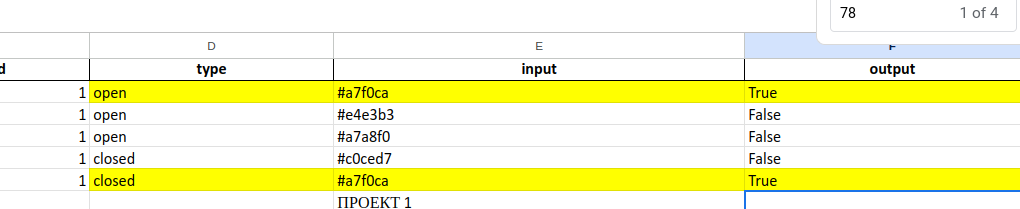
в solutions же указанно "Ошибка в открытых тестах."

In [22]:
# 13 решение
logo_project = ['#a7a8f0', '#a7f0ca', '#b3b4e4', '#e4b3cd', '#e4e3b3', '#c0ced7']
cite_project = ['#e4e3b3', '#a7a8f0', '#ccb1e6', '#b4f99e', '#f9b59e', '#c0ced7']

color = "#a7f0ca"

if color in logo_project and color in cite_project:
    print(True)
else:
    print(False)

False


In [24]:
df_solutions_train_with_tests.to_excel(f'{path_to_data}/test/df_solutions_train_with_test.xlsx')

## Test

In [26]:
df_solutions_test = pd.read_excel(f'{path_to_data}/test/solutions.xlsx')
df_tests_test = pd.read_excel(f'{path_to_data}/test/tests.xlsx')
df_tasks_test = pd.read_excel(f'{path_to_data}/test/tasks.xlsx')

In [27]:
df_solutions_test_with_tests = checkout_tests(df_solutions_test, df_tests_test)
df_solutions_test_with_tests.head()

Processing solutions: 100%|██████████| 325/325 [00:43<00:00,  7.39it/s]


,id,task_id,student_solution,author_comment,author_comment_embedding,error_open,error_closed
0,0,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,True,True
1,1,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,False,False
2,2,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,False,False
3,3,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,True,True
4,4,0,discount = float(input())\nmoney = int(input(...,Ваше предсказание,NaN,True,True


In [28]:
#Solution 0, test 0
discount  = float(0.1)
money = int(500)

#ваш код ниже

print('Реализация проекта будет стоить {money} тыс. руб. без скидки. Со скидой стоимость составит {money- (money * discount)} тыс. руб.')
# test 0 - Реализация проекта будет стоить 500 тыс. руб. без скидки. Со скидкой стоимость составит 450.0 тыс. руб.
# test 3 - Реализация проекта будет стоить 100 тыс. руб. без скидки. Со скидкой стоимость составит 50.0 тыс. руб.

Реализация проекта будет стоить {money} тыс. руб. без скидки. Со скидой стоимость составит {money- (money * discount)} тыс. руб.


In [29]:
df_solutions_train_with_tests.to_excel(f'{path_to_data}/train/df_solutions_train_with_tests.xlsx')